In [68]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import KFold, cross_val_score

In [17]:
#load data as Pandas Dataframes
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_data = train_df.values
test_data = test_df.values

In [16]:
len(train_data)

1460

/Users/huiyanghu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


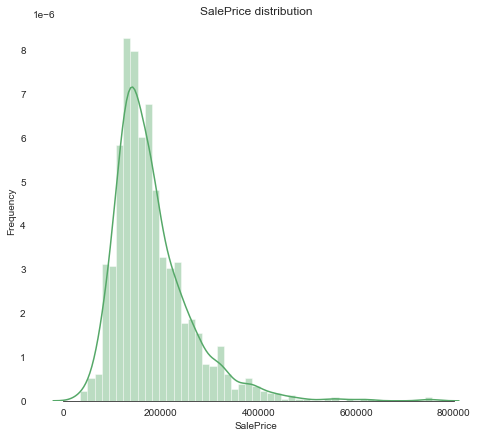

In [36]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
# Check the new distribution
sns.distplot(train_df['SalePrice'], color="g");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()


In [35]:
# Skew and kurt
print("Skewness: %f" % train_df['SalePrice'].skew())
print("Kurtosis: %f" % train_df['SalePrice'].kurt())


Skewness: 1.882876
Kurtosis: 6.536282


<AxesSubplot:>

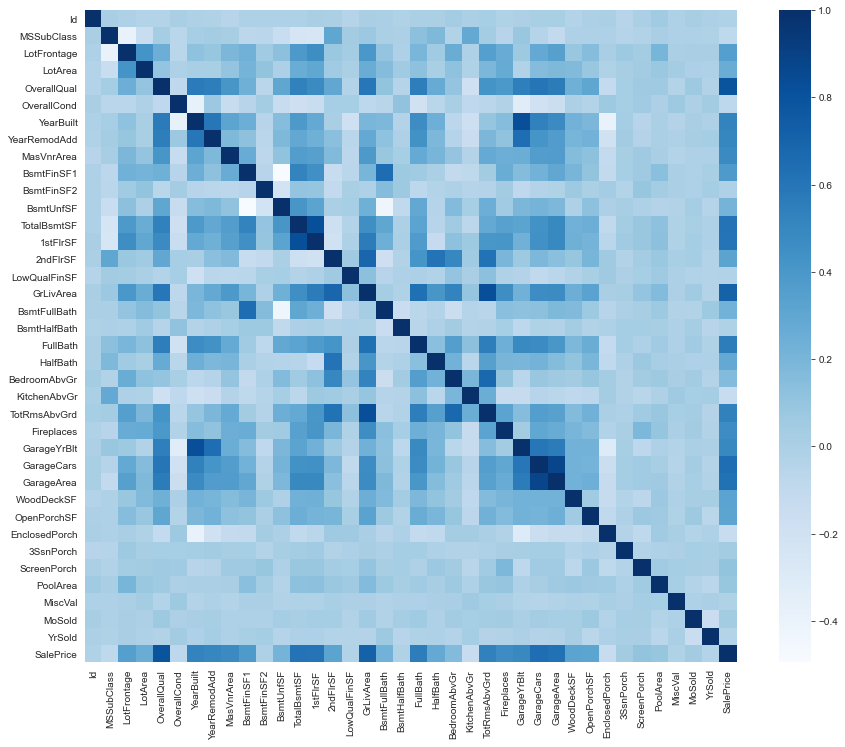

In [39]:
corr = train_df.corr()
plt.subplots(figsize = (15,12))
sns.heatmap(corr, cmap = "Blues", square = True )

In [41]:
# Since it is not normal distribution, we need to fix the skew by applying log(1+x) transform
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])

/Users/huiyanghu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 12.02 and sigma = 0.40



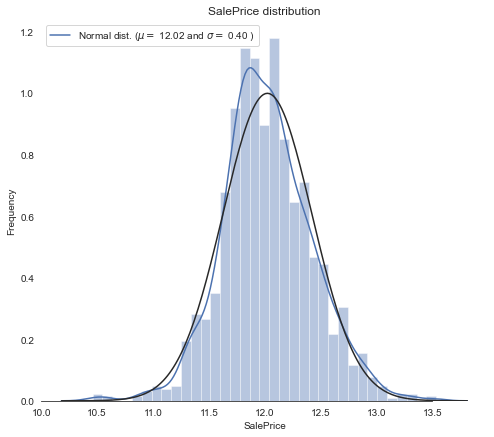

In [52]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train_df['SalePrice'] , fit =stats.norm ,color="b");

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(train_df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)

plt.show()

In [76]:
# determine the threshold for missing values
def percent_missing(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
    return dict_x

missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('LotFrontage', 16.66),
 ('GarageYrBlt', 5.45),
 ('MasVnrArea', 0.79),
 ('BsmtFullBath', 0.07),
 ('BsmtHalfBath', 0.07),
 ('BsmtFinSF1', 0.03),
 ('BsmtFinSF2', 0.03),
 ('BsmtUnfSF', 0.03),
 ('TotalBsmtSF', 0.03),
 ('GarageCars', 0.03)]

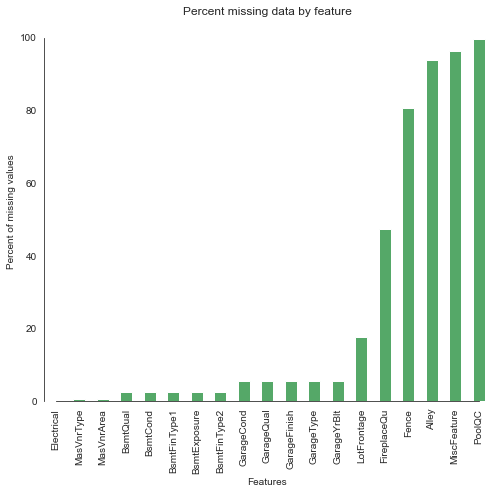

In [80]:
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
sns.set_color_codes(palette='deep')
missing = round(train_df.isnull().mean()*100,2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color="g")
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Percent of missing values")
ax.set(xlabel="Features")
ax.set(title="Percent missing data by feature")
sns.despine(trim=True, right=True)

In [55]:
# Remove outliers
train_df.drop(train_df[(train_df['OverallQual']<5) & (train_df['SalePrice']>200000)].index, inplace=True)
train_df.drop(train_df[(train_df['GrLivArea']>4500) & (train_df['SalePrice']<300000)].index, inplace=True)
train_df.reset_index(drop=True, inplace=True)


In [57]:
# Split features and labels
train_labels = train_df['SalePrice'].reset_index(drop=True)
train_features = train_df.drop(['SalePrice'], axis=1)
test_features = test_df

# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape

(2917, 80)

In [72]:
# Some of the non-numeric predictors are stored as numbers; convert them into strings 
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)


In [85]:
X = train_df[['MoSold','YrSold','LotArea','BedroomAbvGr']]
Y = train_df[['SalePrice']]
# and the data for the competition submission...
X_test = test_df[['MoSold','YrSold','LotArea','BedroomAbvGr']]
print(X.head())
print(Y.head())

   MoSold  YrSold  LotArea  BedroomAbvGr
0       2    2008     8450             3
1       5    2007     9600             3
2       9    2008    11250             3
3       2    2006     9550             3
4      12    2008    14260             4
   SalePrice
0  12.247699
1  12.109016
2  12.317171
3  11.849405
4  12.429220


In [87]:
from sklearn.ensemble import RandomForestRegressor as rfr
estimators = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
mean_rfrs = []
std_rfrs_upper = []
std_rfrs_lower = []
yt = [i for i in Y['SalePrice']] # quick pre-processing of the target
np.random.seed(11111)
for i in estimators:
    model = rfr(n_estimators=i,max_depth=None)
    scores_rfr = cross_val_score(model,X,yt,cv=10,scoring='explained_variance')
    print('estimators:',i)
#     print('explained variance scores for k=10 fold validation:',scores_rfr)
    print("Est. explained variance: %0.2f (+/- %0.2f)" % (scores_rfr.mean(), scores_rfr.std() * 2))
    print('')
    mean_rfrs.append(scores_rfr.mean())
    std_rfrs_upper.append(scores_rfr.mean()+scores_rfr.std()*2) # for error plotting
    std_rfrs_lower.append(scores_rfr.mean()-scores_rfr.std()*2) # for error plotting

estimators: 2
Est. explained variance: -0.16 (+/- 0.35)

estimators: 5
Est. explained variance: 0.04 (+/- 0.18)

estimators: 10
Est. explained variance: 0.11 (+/- 0.17)

estimators: 15
Est. explained variance: 0.12 (+/- 0.21)

estimators: 20
Est. explained variance: 0.12 (+/- 0.17)

estimators: 25
Est. explained variance: 0.13 (+/- 0.20)

estimators: 30
Est. explained variance: 0.15 (+/- 0.17)

estimators: 35
Est. explained variance: 0.15 (+/- 0.20)

estimators: 40
Est. explained variance: 0.15 (+/- 0.17)

estimators: 45
Est. explained variance: 0.16 (+/- 0.17)

estimators: 50
Est. explained variance: 0.16 (+/- 0.18)

estimators: 55
Est. explained variance: 0.17 (+/- 0.17)

estimators: 60
Est. explained variance: 0.17 (+/- 0.18)

estimators: 65
Est. explained variance: 0.16 (+/- 0.18)

estimators: 70
Est. explained variance: 0.16 (+/- 0.17)

estimators: 75
Est. explained variance: 0.16 (+/- 0.17)

estimators: 80
Est. explained variance: 0.15 (+/- 0.19)



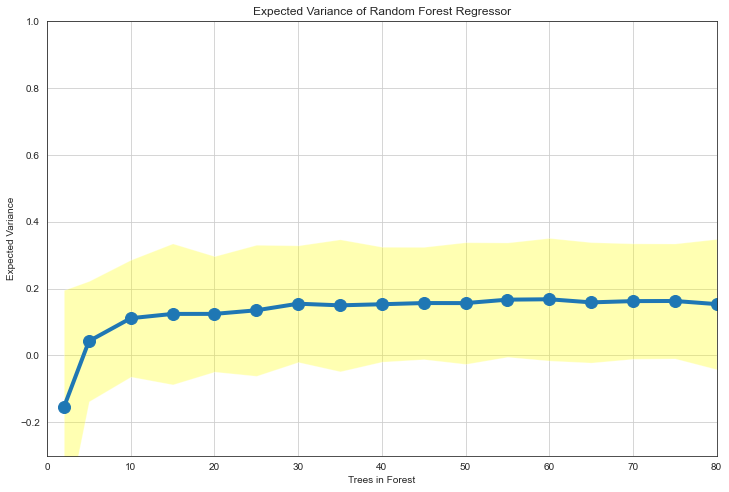

In [89]:
# and plot...
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(estimators,mean_rfrs,marker='o',
       linewidth=4,markersize=12)
ax.fill_between(estimators,std_rfrs_lower,std_rfrs_upper,
                facecolor='yellow',alpha=0.3,interpolate=True)
ax.set_ylim([-.3,1])
ax.set_xlim([0,80])
plt.title('Expected Variance of Random Forest Regressor')
plt.ylabel('Expected Variance')
plt.xlabel('Trees in Forest')
plt.grid()
plt.show()


In [61]:
# Regressor
rf = RandomForestRegressor(n_estimators = 1200,
                           max_depth = 15,
                           min_samples_split = 5,
                           min_samples_leaf = 5,
                           max_features = None,
                           oob_score = True,
                           random_state = 42)


In [62]:
all_features = pd.get_dummies(all_features).reset_index(drop=True)
all_features.shape


(2917, 288)

In [69]:
# Setup cross validation folds
kf = KFold(n_splits=12, random_state=42, shuffle=True)

In [70]:
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

NameError: name 'X' is not defined

In [71]:
rf.fit(all_features, train_df)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [63]:
score = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

NameError: name 'cv_rmse' is not defined

In [64]:
#train model/ ravel to flatten the array structure from [[]] to []
model = clf.fit(train[:,1:], train[:,0].ravel())
# evaluate on testdata
output = model.predict(test[:,1:])
# calculate accuracy
acc = np.mean(output == test[:,0].ravel()) * 100 # calculate accuracy
print("The accuracy of the pure RandomForest classifier is : \t", acc, "%")

ValueError: could not convert string to float: 'RL'